# Optimized inference deployment

In this section, we’ll explore advanced frameworks for optimizing LLM deployments: Text Generation Inference (TGI), vLLM, and llama.cpp. These applications are primarily used in production environments to serve LLMs to users. This section focuses on how to deploy these frameworks in production rather than how to use them for inference on a single machine.

We’ll cover how these tools maximize inference efficiency and simplify production deployments of Large Language Models.

## Framework Selection Guide
TGI, vLLM, and llama.cpp serve similar purposes but have distinct characteristics that make them better suited for different use cases. Let’s look at the key differences between them, focusing on performance and integration.

## Memory Management and Performance
### TGI 
is designed to be stable and predictable in production, using fixed sequence lengths to keep memory usage consistent. TGI manages memory using Flash Attention 2 and continuous batching techniques. This means it can process attention calculations very efficiently and keep the GPU busy by constantly feeding it work. The system can move parts of the model between CPU and GPU when needed, which helps handle larger models.

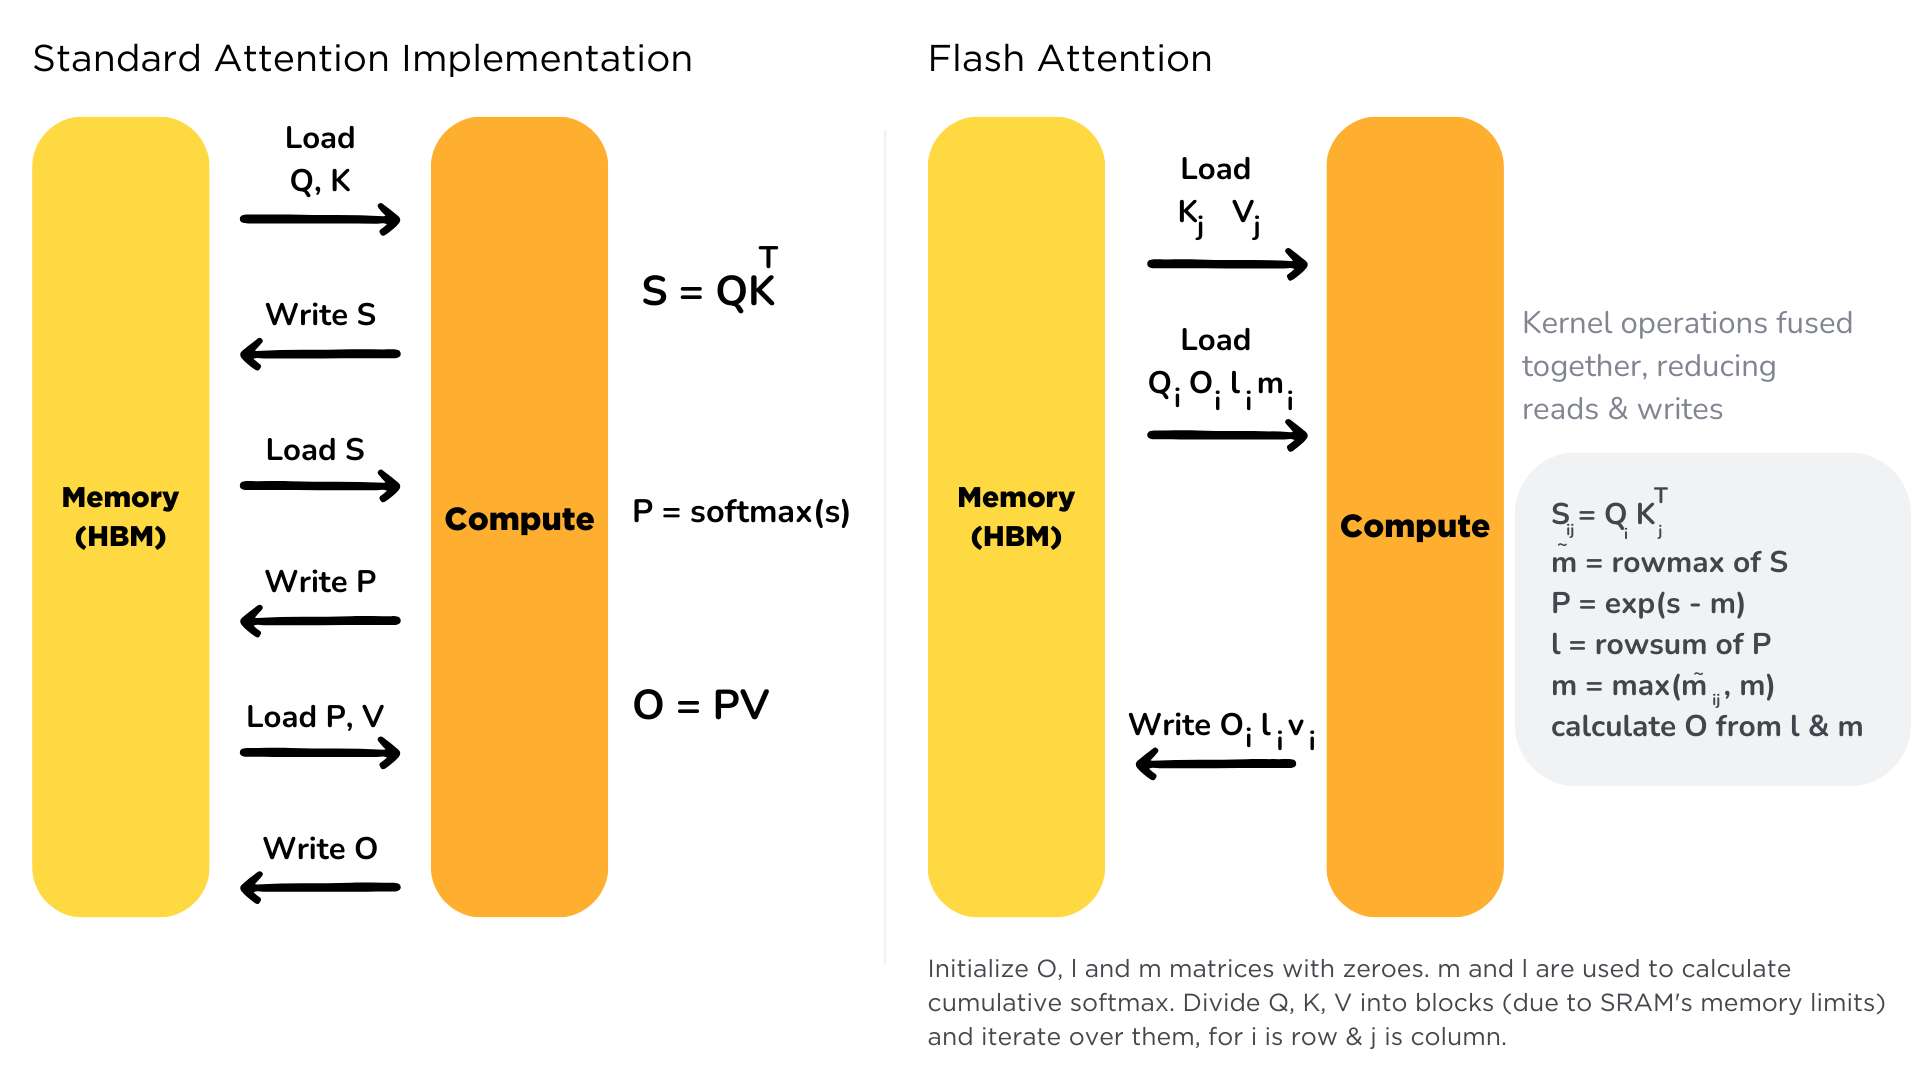

Flash Attention is a technique that optimizes the attention mechanism in transformer models by addressing memory bandwidth bottlenecks. As discussed earlier in Chapter 1.8, the attention mechanism has quadratic complexity and memory usage, making it inefficient for long sequences.

The key innovation is in how it manages memory transfers between High Bandwidth Memory (HBM) and faster SRAM cache. Traditional attention repeatedly transfers data between HBM and SRAM, creating bottlenecks by leaving the GPU idle. Flash Attention loads data once into SRAM and performs all calculations there, minimizing expensive memory transfers.

While the benefits are most significant during training, Flash Attention’s reduced VRAM usage and improved efficiency make it valuable for inference as well, enabling faster and more scalable LLM serving.

### vLLM 
takes a different approach by using PagedAttention. Just like how a computer manages its memory in pages, vLLM splits the model’s memory into smaller blocks. This clever system means it can handle different-sized requests more flexibly and doesn’t waste memory space. It’s particularly good at sharing memory between different requests and reduces memory fragmentation, which makes the whole system more efficient.

PagedAttention is a technique that addresses another critical bottleneck in LLM inference: KV cache memory management. As discussed in Chapter 1.8, during text generation, the model stores attention keys and values (KV cache) for each generated token to reduce redundant computations. The KV cache can become enormous, especially with long sequences or multiple concurrent requests.

vLLM’s key innovation lies in how it manages this cache:

Memory Paging: Instead of treating the KV cache as one large block, it’s divided into fixed-size “pages” (similar to virtual memory in operating systems).
Non-contiguous Storage: Pages don’t need to be stored contiguously in GPU memory, allowing for more flexible memory allocation.
Page Table Management: A page table tracks which pages belong to which sequence, enabling efficient lookup and access.
Memory Sharing: For operations like parallel sampling, pages storing the KV cache for the prompt can be shared across multiple sequences.
The PagedAttention approach can lead to up to 24x higher throughput compared to traditional methods, making it a game-changer for production LLM deployments. If you want to go really deep into how PagedAttention works, you can read the the guide from the vLLM documentation.

### llama.cpp 
is a highly optimized C/C++ implementation originally designed for running LLaMA models on consumer hardware. It focuses on CPU efficiency with optional GPU acceleration and is ideal for resource-constrained environments. llama.cpp uses quantization techniques to reduce model size and memory requirements while maintaining good performance. It implements optimized kernels for various CPU architectures and supports basic KV cache management for efficient token generation.

Quantization in llama.cpp reduces the precision of model weights from 32-bit or 16-bit floating point to lower precision formats like 8-bit integers (INT8), 4-bit, or even lower. This significantly reduces memory usage and improves inference speed with minimal quality loss.

Key quantization features in llama.cpp include:

Multiple Quantization Levels: Supports 8-bit, 4-bit, 3-bit, and even 2-bit quantization
GGML/GGUF Format: Uses custom tensor formats optimized for quantized inference
Mixed Precision: Can apply different quantization levels to different parts of the model
Hardware-Specific Optimizations: Includes optimized code paths for various CPU architectures (AVX2, AVX-512, NEON)
This approach enables running billion-parameter models on consumer hardware with limited memory, making it perfect for local deployments and edge devices.

## Deployment and Integration
Let’s move on to the deployment and integration differences between the frameworks.

1) TGI excels in enterprise-level deployment with its production-ready features. It comes with built-in Kubernetes support and includes everything you need for running in production, like monitoring through Prometheus and Grafana, automatic scaling, and comprehensive safety features. The system also includes enterprise-grade logging and various protective measures like content filtering and rate limiting to keep your deployment secure and stable.

2) vLLM takes a more flexible, developer-friendly approach to deployment. It’s built with Python at its core and can easily replace OpenAI’s API in your existing applications. The framework focuses on delivering raw performance and can be customized to fit your specific needs. It works particularly well with Ray for managing clusters, making it a great choice when you need high performance and adaptability.

3) llama.cpp prioritizes simplicity and portability. Its server implementation is lightweight and can run on a wide range of hardware, from powerful servers to consumer laptops and even some high-end mobile devices. With minimal dependencies and a simple C/C++ core, it’s easy to deploy in environments where installing Python frameworks would be challenging. The server provides an OpenAI-compatible API while maintaining a much smaller resource footprint than other solutions.

## Getting Started
Let’s explore how to use these frameworks for deploying LLMs, starting with installation and basic setup.

### Installation and Basic Setup


TGI is easy to install and use, with deep integration into the Hugging Face ecosystem.

First, launch the TGI server using Docker:

Then interact with it using Hugging Face’s InferenceClient:

In [ ]:
from huggingface_hub import InferenceClient

# Initialize client pointing to TGI endpoint
client = InferenceClient(
    model="http://localhost:8080",  # URL to the TGI server
)

# Text generation
response = client.text_generation(
    "Tell me a story",
    max_new_tokens=100,
    temperature=0.7,
    top_p=0.95,
    details=True,
    stop_sequences=[],
)
print(response.generated_text)

# For chat format
response = client.chat_completion(
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Tell me a story"},
    ],
    max_tokens=100,
    temperature=0.7,
    top_p=0.95,
)
print(response.choices[0].message.content)

Alternatively, you can use the OpenAI client:

In [ ]:
from openai import OpenAI

# Initialize client pointing to TGI endpoint
client = OpenAI(
    base_url="http://localhost:8080/v1",  # Make sure to include /v1
    api_key="not-needed",  # TGI doesn't require an API key by default
)

# Chat completion
response = client.chat.completions.create(
    model="HuggingFaceTB/SmolLM2-360M-Instruct",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Tell me a story"},
    ],
    max_tokens=100,
    temperature=0.7,
    top_p=0.95,
)
print(response.choices[0].message.content)

llama.cpp is easy to install and use, requiring minimal dependencies and supporting both CPU and GPU inference.

First, install and build llama.cpp:

In [ ]:
# Clone the repository
git clone https://github.com/ggerganov/llama.cpp
cd llama.cpp

# Build the project
make

# Download the SmolLM2-1.7B-Instruct-GGUF model
curl -L -O https://huggingface.co/HuggingFaceTB/SmolLM2-1.7B-Instruct-GGUF/resolve/main/smollm2-1.7b-instruct.Q4_K_M.gguf

Then, launch the server (with OpenAI API compatibility):

Interact with the server using Hugging Face’s InferenceClient:

In [ ]:
from huggingface_hub import InferenceClient

# Initialize client pointing to llama.cpp server
client = InferenceClient(
    model="http://localhost:8080/v1",  # URL to the llama.cpp server
    token="sk-no-key-required",  # llama.cpp server requires this placeholder
)

# Text generation
response = client.text_generation(
    "Tell me a story",
    max_new_tokens=100,
    temperature=0.7,
    top_p=0.95,
    details=True,
)
print(response.generated_text)

# For chat format
response = client.chat_completion(
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Tell me a story"},
    ],
    max_tokens=100,
    temperature=0.7,
    top_p=0.95,
)
print(response.choices[0].message.content)

Alternatively, you can use the OpenAI client:

In [ ]:
from openai import OpenAI

# Initialize client pointing to llama.cpp server
client = OpenAI(
    base_url="http://localhost:8080/v1",
    api_key="sk-no-key-required",  # llama.cpp server requires this placeholder
)

# Chat completion
response = client.chat.completions.create(
    model="smollm2-1.7b-instruct",  # Model identifier can be anything as server only loads one model
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Tell me a story"},
    ],
    max_tokens=100,
    temperature=0.7,
    top_p=0.95,
)
print(response.choices[0].message.content)

vLLM is easy to install and use, with both OpenAI API compatibility and a native Python interface.

First, launch the vLLM OpenAI-compatible server:

Then interact with it using Hugging Face’s InferenceClient:

In [ ]:
from huggingface_hub import InferenceClient

# Initialize client pointing to vLLM endpoint
client = InferenceClient(
    model="http://localhost:8000/v1",  # URL to the vLLM server
)

# Text generation
response = client.text_generation(
    "Tell me a story",
    max_new_tokens=100,
    temperature=0.7,
    top_p=0.95,
    details=True,
)
print(response.generated_text)

# For chat format
response = client.chat_completion(
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Tell me a story"},
    ],
    max_tokens=100,
    temperature=0.7,
    top_p=0.95,
)
print(response.choices[0].message.content)

Alternatively, you can use the OpenAI client:

In [ ]:
from openai import OpenAI

# Initialize client pointing to vLLM endpoint
client = OpenAI(
    base_url="http://localhost:8000/v1",
    api_key="not-needed",  # vLLM doesn't require an API key by default
)

# Chat completion
response = client.chat.completions.create(
    model="HuggingFaceTB/SmolLM2-360M-Instruct",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Tell me a story"},
    ],
    max_tokens=100,
    temperature=0.7,
    top_p=0.95,
)
print(response.choices[0].message.content)

Basic Text Generation
Let’s look at examples of text generation with the frameworks:

First, deploy TGI with advanced parameters:

Use the InferenceClient for flexible text generation:

In [ ]:
from huggingface_hub import InferenceClient

client = InferenceClient(model="http://localhost:8080")

# Advanced parameters example
response = client.chat_completion(
    messages=[
        {"role": "system", "content": "You are a creative storyteller."},
        {"role": "user", "content": "Write a creative story"},
    ],
    temperature=0.8,
    max_tokens=200,
    top_p=0.95,
)
print(response.choices[0].message.content)

# Raw text generation
response = client.text_generation(
    "Write a creative story about space exploration",
    max_new_tokens=200,
    temperature=0.8,
    top_p=0.95,
    repetition_penalty=1.1,
    do_sample=True,
    details=True,
)
print(response.generated_text)

Or use the OpenAI client:

In [ ]:
from openai import OpenAI

client = OpenAI(base_url="http://localhost:8080/v1", api_key="not-needed")

# Advanced parameters example
response = client.chat.completions.create(
    model="HuggingFaceTB/SmolLM2-360M-Instruct",
    messages=[
        {"role": "system", "content": "You are a creative storyteller."},
        {"role": "user", "content": "Write a creative story"},
    ],
    temperature=0.8,  # Higher for more creativity
)
print(response.choices[0].message.content)

For llama.cpp, you can set advanced parameters when launching the server:

Use the InferenceClient:

In [ ]:
from huggingface_hub import InferenceClient

client = InferenceClient(model="http://localhost:8080/v1", token="sk-no-key-required")

# Advanced parameters example
response = client.chat_completion(
    messages=[
        {"role": "system", "content": "You are a creative storyteller."},
        {"role": "user", "content": "Write a creative story"},
    ],
    temperature=0.8,
    max_tokens=200,
    top_p=0.95,
)
print(response.choices[0].message.content)

# For direct text generation
response = client.text_generation(
    "Write a creative story about space exploration",
    max_new_tokens=200,
    temperature=0.8,
    top_p=0.95,
    repetition_penalty=1.1,
    details=True,
)
print(response.generated_text)

Or use the OpenAI client for generation with control over the sampling parameters:

In [ ]:
from openai import OpenAI

client = OpenAI(base_url="http://localhost:8080/v1", api_key="sk-no-key-required")

# Advanced parameters example
response = client.chat.completions.create(
    model="smollm2-1.7b-instruct",
    messages=[
        {"role": "system", "content": "You are a creative storyteller."},
        {"role": "user", "content": "Write a creative story"},
    ],
    temperature=0.8,  # Higher for more creativity
    top_p=0.95,  # Nucleus sampling probability
    frequency_penalty=0.5,  # Reduce repetition of frequent tokens
    presence_penalty=0.5,  # Reduce repetition by penalizing tokens already present
    max_tokens=200,  # Maximum generation length
)
print(response.choices[0].message.content)

You can also use llama.cpp’s native library for even more control:

In [ ]:
# Using llama-cpp-python package for direct model access
from llama_cpp import Llama

# Load the model
llm = Llama(
    model_path="smollm2-1.7b-instruct.Q4_K_M.gguf",
    n_ctx=4096,  # Context window size
    n_threads=8,  # CPU threads
    n_gpu_layers=0,  # GPU layers (0 = CPU only)
)

# Format prompt according to the model's expected format
prompt = """<|im_start|>system
You are a creative storyteller.
<|im_end|>
<|im_start|>user
Write a creative story
<|im_end|>
<|im_start|>assistant
"""

# Generate response with precise parameter control
output = llm(
    prompt,
    max_tokens=200,
    temperature=0.8,
    top_p=0.95,
    frequency_penalty=0.5,
    presence_penalty=0.5,
    stop=["<|im_end|>"],
)

print(output["choices"][0]["text"])

For advanced usage with vLLM, you can use the InferenceClient:

In [ ]:
from huggingface_hub import InferenceClient

client = InferenceClient(model="http://localhost:8000/v1")

# Advanced parameters example
response = client.chat_completion(
    messages=[
        {"role": "system", "content": "You are a creative storyteller."},
        {"role": "user", "content": "Write a creative story"},
    ],
    temperature=0.8,
    max_tokens=200,
    top_p=0.95,
)
print(response.choices[0].message.content)

# For direct text generation
response = client.text_generation(
    "Write a creative story about space exploration",
    max_new_tokens=200,
    temperature=0.8,
    top_p=0.95,
    details=True,
)
print(response.generated_text)

You can also use the OpenAI client:

In [ ]:
from openai import OpenAI

client = OpenAI(base_url="http://localhost:8000/v1", api_key="not-needed")

# Advanced parameters example
response = client.chat.completions.create(
    model="HuggingFaceTB/SmolLM2-360M-Instruct",
    messages=[
        {"role": "system", "content": "You are a creative storyteller."},
        {"role": "user", "content": "Write a creative story"},
    ],
    temperature=0.8,
    top_p=0.95,
    max_tokens=200,
)
print(response.choices[0].message.content)

vLLM also provides a native Python interface with fine-grained control:

In [ ]:
from vllm import LLM, SamplingParams

# Initialize the model with advanced parameters
llm = LLM(
    model="HuggingFaceTB/SmolLM2-360M-Instruct",
    gpu_memory_utilization=0.85,
    max_num_batched_tokens=8192,
    max_num_seqs=256,
    block_size=16,
)

# Configure sampling parameters
sampling_params = SamplingParams(
    temperature=0.8,  # Higher for more creativity
    top_p=0.95,  # Consider top 95% probability mass
    max_tokens=100,  # Maximum length
    presence_penalty=1.1,  # Reduce repetition
    frequency_penalty=1.1,  # Reduce repetition
    stop=["\n\n", "###"],  # Stop sequences
)

# Generate text
prompt = "Write a creative story"
outputs = llm.generate(prompt, sampling_params)
print(outputs[0].outputs[0].text)

# For chat-style interactions
chat_prompt = [
    {"role": "system", "content": "You are a creative storyteller."},
    {"role": "user", "content": "Write a creative story"},
]
formatted_prompt = llm.get_chat_template()(chat_prompt)  # Uses model's chat template
outputs = llm.generate(formatted_prompt, sampling_params)
print(outputs[0].outputs[0].text)

## Advanced Generation Control
### Token Selection and Sampling
The process of generating text involves selecting the next token at each step. This selection process can be controlled through various parameters:

1) Raw Logits: The initial output probabilities for each token
2) Temperature: Controls randomness in selection (higher = more creative)
3) Top-p (Nucleus) Sampling: Filters to top tokens making up X% of probability mass
4) Top-k Filtering: Limits selection to k most likely tokens
Here’s how to configure these parameters:

In [ ]:
#tgi
client.generate(
    "Write a creative story",
    temperature=0.8,  # Higher for more creativity
    top_p=0.95,  # Consider top 95% probability mass
    top_k=50,  # Consider top 50 tokens
    max_new_tokens=100,  # Maximum length
    repetition_penalty=1.1,  # Reduce repetition
)

In [ ]:
#llama
# Via OpenAI API compatibility
response = client.completions.create(
    model="smollm2-1.7b-instruct",  # Model name (can be any string for llama.cpp server)
    prompt="Write a creative story",
    temperature=0.8,  # Higher for more creativity
    top_p=0.95,  # Consider top 95% probability mass
    frequency_penalty=1.1,  # Reduce repetition
    presence_penalty=0.1,  # Reduce repetition
    max_tokens=100,  # Maximum length
)

# Via llama-cpp-python direct access
output = llm(
    "Write a creative story",
    temperature=0.8,
    top_p=0.95,
    top_k=50,
    max_tokens=100,
    repeat_penalty=1.1,
)

In [ ]:
#vLLM
params = SamplingParams(
    temperature=0.8,  # Higher for more creativity
    top_p=0.95,  # Consider top 95% probability mass
    top_k=50,  # Consider top 50 tokens
    max_tokens=100,  # Maximum length
    presence_penalty=0.1,  # Reduce repetition
)
llm.generate("Write a creative story", sampling_params=params)

### Controlling Repetition
Both frameworks provide ways to prevent repetitive text generation:

In [ ]:
#TGI
client.generate(
    "Write a varied text",
    repetition_penalty=1.1,  # Penalize repeated tokens
    no_repeat_ngram_size=3,  # Prevent 3-gram repetition
)

In [ ]:
#llama
# Via OpenAI API
response = client.completions.create(
    model="smollm2-1.7b-instruct",
    prompt="Write a varied text",
    frequency_penalty=1.1,  # Penalize frequent tokens
    presence_penalty=0.8,  # Penalize tokens already present
)

# Via direct library
output = llm(
    "Write a varied text",
    repeat_penalty=1.1,  # Penalize repeated tokens
    frequency_penalty=0.5,  # Additional frequency penalty
    presence_penalty=0.5,  # Additional presence penalty
)

In [ ]:
#vLLM
params = SamplingParams(
    presence_penalty=0.1,  # Penalize token presence
    frequency_penalty=0.1,  # Penalize token frequency
)

### Length Control and Stop Sequences
You can control generation length and specify when to stop:

In [3]:
#TGI
client.generate(
    "Generate a short paragraph",
    max_new_tokens=100,
    min_new_tokens=10,
    stop_sequences=["\n\n", "###"],
)

In [ ]:
# llama
# Via OpenAI API
response = client.completions.create(
    model="smollm2-1.7b-instruct",
    prompt="Generate a short paragraph",
    max_tokens=100,
    stop=["\n\n", "###"],
)

# Via direct library
output = llm("Generate a short paragraph", max_tokens=100, stop=["\n\n", "###"])

In [ ]:
#vLLM
params = SamplingParams(
    max_tokens=100,
    min_tokens=10,
    stop=["###", "\n\n"],
    ignore_eos=False,
    skip_special_tokens=True,
)

## Memory Management
Both frameworks implement advanced memory management techniques for efficient inference.

<hfoption value="tgi" label="TGI">
TGI uses Flash Attention 2 and continuous batching:

llama.cpp uses quantization and optimized memory layout:

For models too large for your GPU, you can use CPU offloading:

vLLM uses PagedAttention for optimal memory management:

In [ ]:
from vllm.engine.arg_utils import AsyncEngineArgs

engine_args = AsyncEngineArgs(
    model="HuggingFaceTB/SmolLM2-1.7B-Instruct",
    gpu_memory_utilization=0.85,
    max_num_batched_tokens=8192,
    block_size=16,
)

llm = LLM(engine_args=engine_args)